In [23]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm
from pathlib import Path

# Dataset

In [2]:
df1 = pd.read_csv("dataset/scenario1.csv", index_col = False, sep = ",")
df2 = pd.read_csv("dataset/scenario2.csv", index_col = False, sep = ",")

# Check

In [3]:
# drop epoch 0 because epoch bootstrapped
df1 = df1[df1["epoch"] != 0]
df2 = df2[df2["epoch"] != 0]

In [4]:
df1.head()

,epoch,node,main,assigned_slots,share_assigned_slots,ok,skipped,invalid,delayed,bad_slots_abs,...,forced_invalid_slots_realized,forced_invalid_share_pct_of_invalid,penalty_gained,penalty_recovery,penalty_tol,residual_prev_dbg,residual_next_dbg,ok_rate,scenario,assigned_share
3,1,OV_1,MAIN_1,9712,40.467,9669,43,0,0,43,...,0,0.0,0.0,0.0,194.24,0.0,0.0,0.995572,1,0.404667
4,1,OV_2,MAIN_2,7160,29.833,7160,0,0,0,0,...,0,0.0,0.0,0.0,143.20,0.0,0.0,1.000000,1,0.298333
5,1,OV_3,MAIN_3,7128,29.700,7096,17,10,5,32,...,0,0.0,0.0,0.0,142.56,0.0,0.0,0.995511,1,0.297000
6,2,OV_1,MAIN_1,9503,39.596,9501,2,0,0,2,...,0,0.0,0.0,0.0,190.06,0.0,0.0,0.999790,1,0.395958
7,2,OV_2,MAIN_2,7276,30.317,7276,0,0,0,0,...,0,0.0,0.0,0.0,145.52,0.0,0.0,1.000000,1,0.303167


In [5]:
df2.head()

,epoch,node,main,assigned_slots,share_assigned_slots,ok,skipped,invalid,delayed,bad_slots_abs,...,penalty_tol,residual_prev_dbg,residual_next_dbg,ok_rate,scenario,assigned_share,malicious_i,post_t,interaction,time_since_switch
3,1,OV_1,MAIN_1,9712,40.467,7577,0,2135,0,2135,...,485.60,0.0,2367.760000,0.780169,2,0.404667,1,0,0,0
4,1,OV_2,MAIN_2,7160,29.833,7132,27,1,0,28,...,358.00,0.0,0.000000,0.996089,2,0.298333,0,0,0,0
5,1,OV_3,MAIN_3,7128,29.700,7128,0,0,0,0,...,356.40,0.0,0.000000,1.000000,2,0.297000,0,0,0,0
6,2,OV_1,MAIN_1,1896,7.900,1434,0,462,0,462,...,94.80,2368.0,2669.559366,0.756329,2,0.079000,1,0,0,0
7,2,OV_2,MAIN_2,11027,45.946,11020,7,0,0,7,...,551.35,0.0,0.000000,0.999365,2,0.459458,0,0,0,0


In [6]:
df1.columns

Index(['epoch', 'node', 'main', 'assigned_slots', 'share_assigned_slots', 'ok',
       'skipped', 'invalid', 'delayed', 'bad_slots_abs', 'bad_slots_pct_node',
       'effective_stake', 'stake_share_pct', 'effective_stake_next',
       'stake_share_next_pct', 'delivered_slots_share_pct',
       'coinbase_epoch_tkg', 'fees_epoch_tkr_at_main',
       'reward_epoch_total_value_tkg_only', 'coinbase_cum_tkg',
       'fees_cum_tkr_at_main', 'penalty_slots_residual', 'penalty_score',
       'forced_invalid_slots_planned', 'forced_invalid_slots_realized',
       'forced_invalid_share_pct_of_invalid', 'penalty_gained',
       'penalty_recovery', 'penalty_tol', 'residual_prev_dbg',
       'residual_next_dbg', 'ok_rate', 'scenario', 'assigned_share'],
      dtype='object')

In [7]:
df2.columns

Index(['epoch', 'node', 'main', 'assigned_slots', 'share_assigned_slots', 'ok',
       'skipped', 'invalid', 'delayed', 'bad_slots_abs', 'bad_slots_pct_node',
       'effective_stake', 'stake_share_pct', 'effective_stake_next',
       'stake_share_next_pct', 'delivered_slots_share_pct',
       'coinbase_epoch_tkg', 'fees_epoch_tkr_at_main',
       'reward_epoch_total_value_tkg_only', 'coinbase_cum_tkg',
       'fees_cum_tkr_at_main', 'penalty_slots_residual', 'penalty_score',
       'forced_invalid_slots_planned', 'forced_invalid_slots_realized',
       'forced_invalid_share_pct_of_invalid', 'penalty_gained',
       'penalty_recovery', 'penalty_tol', 'residual_prev_dbg',
       'residual_next_dbg', 'ok_rate', 'scenario', 'assigned_share',
       'malicious_i', 'post_t', 'interaction', 'time_since_switch'],
      dtype='object')

In [8]:
cols = ['malicious_i', 'post_t', 'interaction']
df2[cols] = df2[cols].astype(int)

In [9]:
for col in cols:
    print(col, df2[col].unique())

malicious_i [1 0]
post_t [0 1]
interaction [0 1]


# Did

In [10]:
mod_reward = smf.ols(
    "reward_epoch_total_value_tkg_only ~ malicious_i + post_t + interaction + C(node)",
    data=df2
).fit(cov_type="cluster", cov_kwds={"groups": df2["node"]})
print(mod_reward.summary())

                                    OLS Regression Results                                   
Dep. Variable:     reward_epoch_total_value_tkg_only   R-squared:                       0.339
Model:                                           OLS   Adj. R-squared:                  0.335
Method:                                Least Squares   F-statistic:                 1.440e+04
Date:                               Wed, 15 Oct 2025   Prob (F-statistic):           6.94e-05
Time:                                       18:49:19   Log-Likelihood:                 71.037
No. Observations:                                597   AIC:                            -132.1
Df Residuals:                                    592   BIC:                            -110.1
Df Model:                                          4                                         
Covariance Type:                             cluster                                         
                      coef    std err          z      P>|z| 

c:\Users\keita\anaconda3\envs\takamaka\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [11]:
mod_stake = smf.ols(
    "effective_stake_next ~ malicious_i + post_t + interaction + C(node)",
    data=df2
).fit(cov_type="cluster", cov_kwds={"groups": df2["node"]})
print(mod_stake.summary())

                             OLS Regression Results                             
Dep. Variable:     effective_stake_next   R-squared:                       0.193
Model:                              OLS   Adj. R-squared:                  0.188
Method:                   Least Squares   F-statistic:                 2.159e+06
Date:                  Wed, 15 Oct 2025   Prob (F-statistic):           4.63e-07
Time:                          18:49:22   Log-Likelihood:                -3659.4
No. Observations:                   597   AIC:                             7329.
Df Residuals:                       592   BIC:                             7351.
Df Model:                             4                                         
Covariance Type:                cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         163.

c:\Users\keita\anaconda3\envs\takamaka\lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 1
  warnings.warn('covariance of constraints does not have full '


# Interrupted Time Series (ITS)


=== ITS for OK rate (node OV_1) ===
                            OLS Regression Results                            
Dep. Variable:                ok_rate   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     5068.
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.11e-184
Time:                        22:53:00   Log-Likelihood:                 623.73
No. Observations:                 199   AIC:                            -1239.
Df Residuals:                     195   BIC:                            -1226.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      

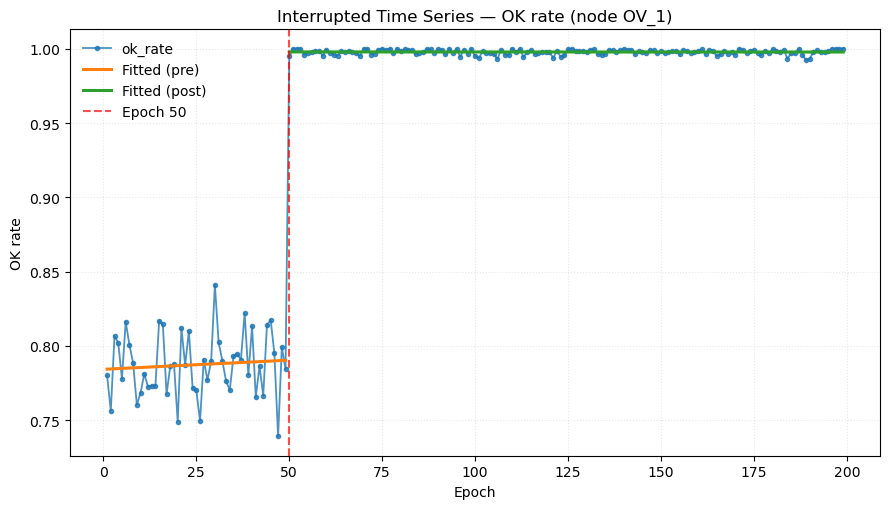


=== ITS for Reward (TKG) (node OV_1) ===
                                    OLS Regression Results                                   
Dep. Variable:     reward_epoch_total_value_tkg_only   R-squared:                       0.847
Model:                                           OLS   Adj. R-squared:                  0.844
Method:                                Least Squares   F-statistic:                     305.4
Date:                               Wed, 15 Oct 2025   Prob (F-statistic):           2.07e-73
Time:                                       22:53:00   Log-Likelihood:                 131.96
No. Observations:                                199   AIC:                            -255.9
Df Residuals:                                    195   BIC:                            -242.7
Df Model:                                          3                                         
Covariance Type:                                 HAC                                         
                 c

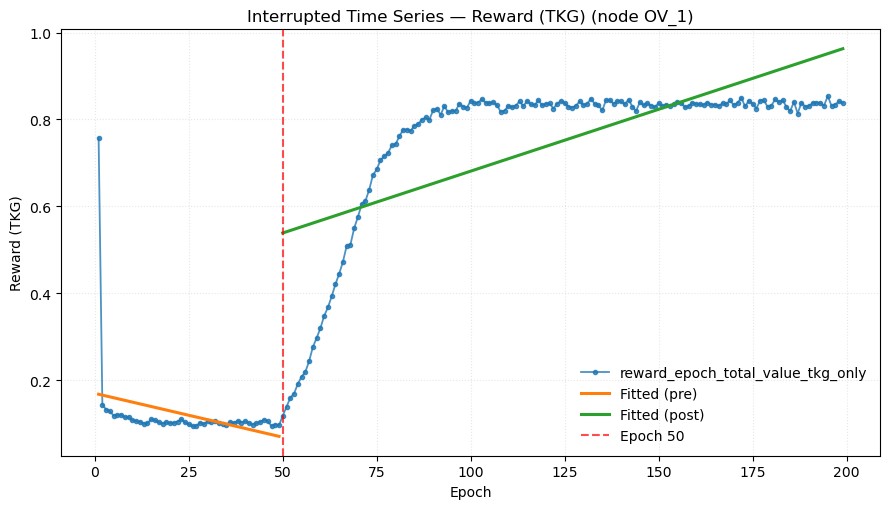


=== ITS for Penalty residual (node OV_1) ===
                              OLS Regression Results                              
Dep. Variable:     penalty_slots_residual   R-squared:                       0.936
Model:                                OLS   Adj. R-squared:                  0.935
Method:                     Least Squares   F-statistic:                     874.3
Date:                    Wed, 15 Oct 2025   Prob (F-statistic):          8.77e-113
Time:                            22:53:01   Log-Likelihood:                -1444.7
No. Observations:                     199   AIC:                             2897.
Df Residuals:                         195   BIC:                             2911.
Df Model:                               3                                         
Covariance Type:                      HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

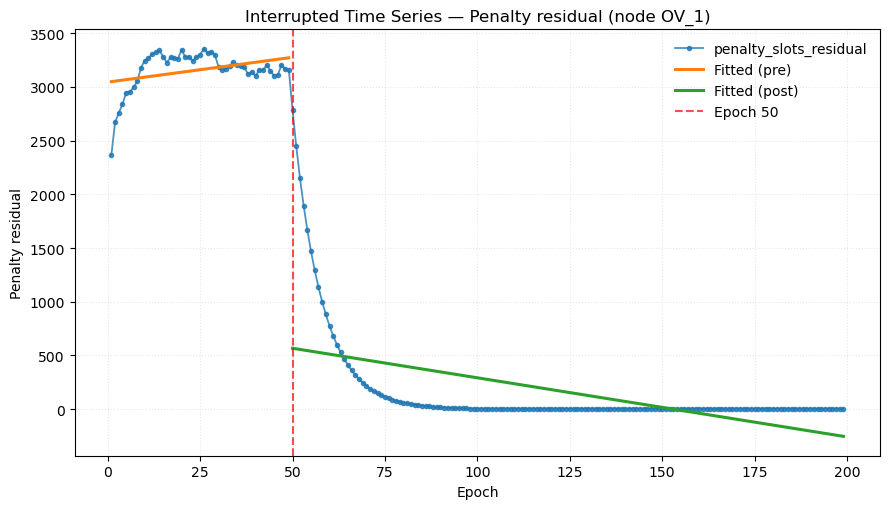

In [24]:
# --- PARAMETRI ---
BREAK_EPOCH = 50        # redemption breakpoint (post_t = 1 se epoch >= 50)
NODE_TREATED = "OV_1"   # ITS solo sul nodo trattato
outdir = Path("fig")
outdir.mkdir(exist_ok=True, parents=True)

# --- Dataset: prendi df2 (scenario con malizia+reden zione) e isola OV_1 ---
s2 = df2.copy()
s2 = s2.rename(columns={
    "reward_epoch_total_value_TKG_only": "reward_epoch_total_value_tkg_only"  # se mai servisse
})
ov1 = s2[s2["node"] == NODE_TREATED].sort_values("epoch").reset_index(drop=True)

# Costruisci regressori ITS
ov1["t"] = np.arange(len(ov1))                       # tempo 0..T
ov1["post_t"] = (ov1["epoch"] >= BREAK_EPOCH).astype(int)
ov1["t_post"] = ov1["t"] * ov1["post_t"]             # interazione slope-change

# Piccolo clip utile se la serie è quasi deterministica (evita numeri strani in grafico)
ov1["ok_rate"] = ov1["ok_rate"].clip(0, 1)

# --- Funzione di stima + grafico ITS ---
def run_its(yvar, nice_name=None, save_name=None, hac_lags=8):
    """
    Stima: Y_t = α0 + α1 t + α2 post_t + α3 (t*post_t) + u_t
    SE: Newey-West (HAC) con maxlags=hac_lags
    """
    if nice_name is None:
        nice_name = yvar
    if save_name is None:
        save_name = yvar

    # OLS con HAC (Newey–West)
    mod = smf.ols(f"{yvar} ~ t + post_t + t_post", data=ov1).fit(
        cov_type="HAC", cov_kwds={"maxlags": hac_lags}
    )

    # Estrai coefficienti (α0, α1, α2, α3)
    a0 = mod.params["Intercept"]
    a1 = mod.params["t"]
    a2 = mod.params["post_t"]     # salto a epoch 50
    a3 = mod.params["t_post"]     # variazione di pendenza post

    print(f"\n=== ITS for {nice_name} (node {NODE_TREATED}) ===")
    print(mod.summary())

    # --- Previsioni pre/post per linee fitted (due rette) ---
    pre = ov1[ov1["post_t"] == 0].copy()
    post = ov1[ov1["post_t"] == 1].copy()

    # pre: α0 + α1 * t
    pre["fit"] = a0 + a1 * pre["t"]
    # post: α0 + α2 + (α1 + α3) * t
    post["fit"] = a0 + a2 + (a1 + a3) * post["t"]

    # --- Grafico ---
    plt.figure(figsize=(9, 5.2))
    plt.plot(ov1["epoch"], ov1[yvar], marker="o", ms=3, lw=1.3, alpha=0.8, label=yvar)
    plt.plot(pre["epoch"], pre["fit"], lw=2.2, label="Fitted (pre)")
    plt.plot(post["epoch"], post["fit"], lw=2.2, label="Fitted (post)")

    # linea verticale sul break
    plt.axvline(BREAK_EPOCH, color="red", linestyle="--", alpha=0.7, label=f"Epoch {BREAK_EPOCH}")

    plt.title(f"Interrupted Time Series — {nice_name} (node {NODE_TREATED})")
    plt.xlabel("Epoch")
    plt.ylabel(nice_name)
    plt.grid(alpha=0.3, linestyle=":")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.savefig(outdir / f"its_{save_name}_ov1.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Ritorna l’oggetto stimato per eventuali tabelle LaTeX
    return mod

# --- Esegui per le tre serie ---
res_ok = run_its("ok_rate", nice_name="OK rate", save_name="ok_rate")
res_rw = run_its("reward_epoch_total_value_tkg_only", nice_name="Reward (TKG)", save_name="reward")
res_pe = run_its("penalty_slots_residual", nice_name="Penalty residual", save_name="penalty")


In [25]:
def coef_table(res, name):
    p = res.params
    se = res.bse
    out = {
        "series": name,
        "alpha2 (post_t)": p.get("post_t", np.nan),
        "se(alpha2)": se.get("post_t", np.nan),
        "alpha3 (t_post)": p.get("t_post", np.nan),
        "se(alpha3)": se.get("t_post", np.nan)
    }
    return out

rows = []
rows.append(coef_table(res_rw, "Reward (TKG)"))
rows.append(coef_table(res_ok, "OK rate"))
rows.append(coef_table(res_pe, "Penalty residual"))

its_df = pd.DataFrame(rows)
its_df


,series,alpha2 (post_t),se(alpha2),alpha3 (t_post),se(alpha3)
0,Reward (TKG),0.231764,0.142317,0.004868,0.001601
1,OK rate,0.213455,0.003223,-0.000124,0.000119
2,Penalty residual,-2212.470834,409.654547,-10.127734,4.888984


In [27]:
def stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

def latex_number(val, se, p):
    # coeff (se) + stars
    return f"{val:.4f}{stars(p)} \\\\ ({se:.4f})"

# p-value from z = coef/se (HAC produce z)
def pvals(res, param):
    coef = res.params.get(param, np.nan)
    se = res.bse.get(param, np.nan)
    if np.isnan(coef) or np.isnan(se) or se == 0:
        return np.nan
    z = coef / se
    try:
        from scipy.stats import norm
        return 2 * (1 - norm.cdf(abs(z)))
    except ImportError:
        # se scipy non è installato, restituisci NaN
        return np.nan


# costruisci latex
def its_to_latex(res_rw, res_ok, res_pe):
    lines = []
    lines.append("\\begin{table}[H]")
    lines.append("\\centering")
    lines.append("\\caption{Interrupted Time Series: jump (\\(\\alpha_2\\)) and slope change (\\(\\alpha_3\\)) for OV\\_1}")
    lines.append("\\label{tab:its_results}")
    lines.append("\\begin{tabular}{lcc}")
    lines.append("\\toprule")
    lines.append(" & $\\alpha_2$ (post) & $\\alpha_3$ (t$\\times$post) \\\\")
    lines.append("\\midrule")

    for name, res in [("Reward (TKG)", res_rw), ("OK rate", res_ok), ("Penalty residual", res_pe)]:
        p2 = pvals(res, "post_t")
        p3 = pvals(res, "t_post")
        a2 = latex_number(res.params.get("post_t", np.nan), res.bse.get("post_t", np.nan), p2 if p2==p2 else 1.0)
        a3 = latex_number(res.params.get("t_post", np.nan), res.bse.get("t_post", np.nan), p3 if p3==p3 else 1.0)
        lines.append(f"{name} & {a2} & {a3} \\\\")
    lines.append("\\bottomrule")
    lines.append("\\multicolumn{3}{l}{\\footnotesize Notes: OLS with Newey--West standard errors (HAC, 8 lags). Stars denote $p<0.05$, $p<0.01$, $p<0.001$.}")
    lines.append("\\end{tabular}")
    lines.append("\\end{table}")
    return "\n".join(lines)

latex_code = its_to_latex(res_rw, res_ok, res_pe)
print(latex_code)


\begin{table}[H]
\centering
\caption{Interrupted Time Series: jump (\(\alpha_2\)) and slope change (\(\alpha_3\)) for OV\_1}
\label{tab:its_results}
\begin{tabular}{lcc}
\toprule
 & $\alpha_2$ (post) & $\alpha_3$ (t$\times$post) \\
\midrule
Reward (TKG) & 0.2318 \\ (0.1423) & 0.0049** \\ (0.0016) \\
OK rate & 0.2135*** \\ (0.0032) & -0.0001 \\ (0.0001) \\
Penalty residual & -2212.4708*** \\ (409.6545) & -10.1277* \\ (4.8890) \\
\bottomrule
\multicolumn{3}{l}{\footnotesize Notes: OLS with Newey--West standard errors (HAC, 8 lags). Stars denote $p<0.05$, $p<0.01$, $p<0.001$.}
\end{tabular}
\end{table}


# Half life

In [28]:
# dati post-break
post = ov1[ov1["post_t"] == 1].copy()
post = post[post["penalty_slots_residual"] > 0].copy()
post["tau"] = post["epoch"] - 50
post["logP"] = np.log(post["penalty_slots_residual"])

halflife_model = smf.ols("logP ~ tau", data=post).fit()
lam = -halflife_model.params["tau"]       # lambda > 0 atteso
t_half = np.log(2) / lam if lam > 0 else np.inf

print(halflife_model.summary())
print(f"Estimated half-life (epochs): {t_half:.2f}")


                            OLS Regression Results                            
Dep. Variable:                   logP   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     241.1
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           7.20e-33
Time:                        22:53:55   Log-Likelihood:                -239.00
No. Observations:                 150   AIC:                             482.0
Df Residuals:                     148   BIC:                             488.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1389      0.195     26.387      0.0